Sistema baseado na rede de distribuição de gás natural

1 Duto

equações :
$$
\frac{\partial}{\partial t}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
=
\begin{bmatrix}
-w & 0 & -T \frac{V^{*} P'_T}{C_V} \\
0 & -w & V \\
- V^{*} P'_T & -V^{*} P'_V & -w
\end{bmatrix}
\frac{\partial}{\partial x}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
+
\begin{bmatrix}
\frac{f w^2 |w|}{2 D C_V} + \frac{q}{C_V} \\
0 \\
\frac{f w |w|}{2 D}
\end{bmatrix}
$$
Retirado da Tese de doutorado em Engenharia Industrial de Rodrigo Lima Meira.

| **Variável**      | **Valor**           | **Unidade**     |
|-------------------|---------------------|-----------------|
| 𝜀                 | 1,5 × 10⁻⁶          | m               |
| κₛₒₗₒ             | 0,89                | W/(m·K)         |
| Tₛₒₗₒ             | 15                  | °C              |
| zₛₒₗₒ             | 2                   | m               |


In [1]:
from casadi import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from libs.viscosity import *
from libs.eos_database import *
from libs.gc_eos_soave import *
from libs.composicaogas import *
from libs.duto import *

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

Vpp = 2.0 
Lc = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4500000, None, 1, 0, Aij, volumn_desviation, 'gas')
visc = viscosity(mixture, volumn_desviation)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
373873.00835531094
nan
nan
nan
nan
nan
nan
nan
nan
373873.05348301795
nan
nan
nan
nan
nan
nan
nan
nan
nan
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5284231263146D-05   r2 =                  NaN
Falha na integração: Unexpected istate in LSODA.


/home/matheusmb/trabalho2/UFBA/New_project_2/libs/duto.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  return (1/ (-16 * np.log(self.e_D / 3.7 - 5.02/ Re * np.log(self.e_D/ 3.7 - 5.02/Re * np.log(self.e_D / 3.7 + 13/Re)))))**2
/home/matheusmb/trabalho2/UFBA/New_project_2/libs/duto.py:25: RuntimeWarning: invalid value encountered in log
  return (1/ (-16 * np.log(self.e_D / 3.7 - 5.02/ Re * np.log(self.e_D/ 3.7 - 5.02/Re * np.log(self.e_D / 3.7 + 13/Re)))))**2
/home/matheusmb/.local/lib/python3.12/site-packages/scipy/integrate/_ivp/lsoda.py:161: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  solver._y, solver.t = integrator.run(


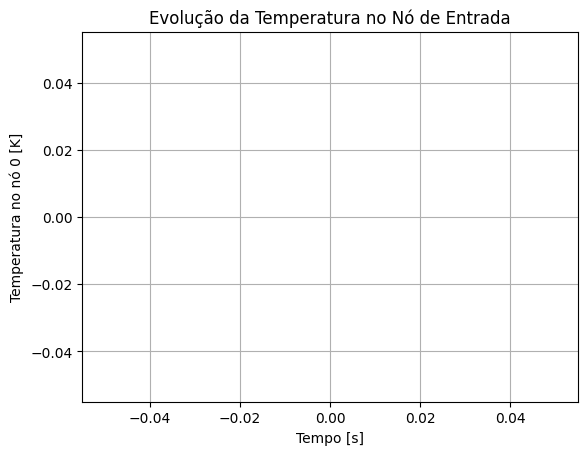

In [ ]:
from scipy.integrate import solve_ivp

# Criar instância do duto com os parâmetros necessários  # ajuste conforme seu import real
meu_duto = duto(gas=gas, visc=visc,  Lc=1000, D=0.5)

# Número de nós (comprimento de self.l)
n_nodes = len(meu_duto.l)

# Condições iniciais
# Temperatura: 300 K, Volume específico: calculado pela entrada, Velocidade: 0 (exceto na saída)
T0 = np.full(n_nodes, 300.0)
P_init = 7500  # kPa
gas_init = gas.copy_change_conditions(T0[0], P_init, None, 'gas')
V0 = np.full(n_nodes, gas_init.V.item())
w0 = np.zeros(n_nodes)

y0 = np.empty(n_nodes * 3)
y0[0::3] = T0
y0[1::3] = V0
y0[2::3] = w0

# Definir wrapper da função para solve_ivp
def dae_wrapper(t, y):
    return meu_duto.evaluate_dae(t, y)

# Intervalo de tempo de simulação
t_span = (0, 10)  # de 0 a 10 segundos
t_eval = np.linspace(*t_span, 200)  # 200 pontos de avaliação

# Resolver a DAE
sol = solve_ivp(
    dae_wrapper,
    t_span=t_span,
    y0=y0,
    method='LSODA',  # pode testar 'BDF' se o sistema for stiff
    t_eval=t_eval,
    vectorized=False
)

# Verificar solução
if sol.success:
    print("Integração bem-sucedida!")
else:
    print("Falha na integração:", sol.message)


plt.plot(sol.t, sol.y[0])  # T no primeiro nó
plt.xlabel('Tempo [s]')
plt.ylabel('Temperatura no nó 0 [K]')
plt.title('Evolução da Temperatura no Nó de Entrada')
plt.grid(True)
plt.show()
